## THIS NOTEBOOK IS BEING CONSTANTLY UPDATED, SO I TRY TO "CUT" SOME ADVANCE AND PUBLISH A VERSION THAT WORKS.


**Import Libraries**

In [1]:
import numpy as np
import pandas as pd
import re
import time
import random

#models
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

#tools
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics

import matplotlib.pyplot as plt


**Load data**

In [2]:
# Load data
train_df = pd.read_csv("../input/spaceship-titanic/train.csv")
test_df = pd.read_csv("../input/spaceship-titanic/test.csv")


# **EXPLORATORY DATA ANALISYS**

First look of the data. What we can see?

* train.csv - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.
    * PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
    * HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
    * CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
    * Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
    * Destination - The planet the passenger will be debarking to.
    * Age - The age of the passenger.
    * VIP - Whether the passenger has paid for special VIP service during the voyage.
    * RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
    * Name - The first and last names of the passenger.
    * Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.

* test.csv - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. Your task is to predict the value of Transported for the passengers in this set.

In [3]:
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True



**Split PassengerId in Ticket and Unique. This is because "grouped tickets"**

In [4]:
train_df[['PassengerId_Ticket', 'PassengerId_Unique']] = train_df['PassengerId'].str.split('_', expand=True)
test_df[['PassengerId_Ticket', 'PassengerId_Unique']] = test_df['PassengerId'].str.split('_', expand=True)



**Create a new column to identify people who travel in group**

In [5]:
# Train df first
serie = []
for i in train_df["PassengerId_Ticket"].values:
    if i in train_df["PassengerId_Ticket"][train_df["PassengerId_Ticket"].duplicated(keep="last")].array:
        serie = np.append(serie,True)
    else:
        serie = np.append(serie,False)
        
train_df['IsGrouped'] = serie.tolist()
train_df = train_df.astype({"IsGrouped": bool})

# Test df

serie = []
for i in test_df["PassengerId_Ticket"].values:
    if i in test_df["PassengerId_Ticket"][test_df["PassengerId_Ticket"].duplicated(keep="last")].array:
        serie = np.append(serie,True)
    else:
        serie = np.append(serie,False)
        
test_df['IsGrouped'] = serie.tolist()
test_df = test_df.astype({"IsGrouped": bool})

train_df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,PassengerId_Ticket,PassengerId_Unique,IsGrouped
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0001,01,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,0002,01,False
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,0003,01,True
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,0003,02,True
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,0004,01,False


## **PLOT THIS FIRST APROACH TO THE DATAFRAME**

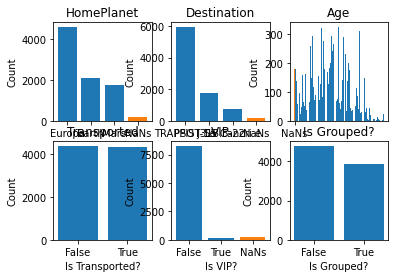

In [6]:
plt.figure()

plt.subplot(2,3,1)
plt.bar(train_df["HomePlanet"].dropna().unique(),train_df["HomePlanet"].value_counts())
plt.bar("NaNs",train_df["HomePlanet"].isna().sum())
plt.title("HomePlanet")
plt.xlabel("Origin")
plt.ylabel("Count")

plt.subplot(2,3,2)
plt.bar(train_df["Destination"].dropna().unique(),train_df["Destination"].value_counts())
plt.bar("NaNs",train_df["Destination"].isna().sum())
plt.title("Destination")
plt.xlabel("Destination")
plt.ylabel("Count")

plt.subplot(2,3,3)
plt.bar(train_df["Age"].dropna().unique(),train_df["Age"].value_counts())
plt.bar("NaNs",train_df["Age"].isna().sum())
plt.title("Age")
plt.xlabel("Age")
plt.ylabel("Count")

plt.subplot(2,3,4)
plt.bar(["False","True"],train_df["Transported"].value_counts())
plt.title("Transported")
plt.ylabel("Count")
plt.xlabel("Is Transported?")

plt.subplot(2,3,5)
plt.bar(["False","True"],train_df["VIP"].value_counts())
plt.bar("NaNs",train_df["VIP"].isna().sum())
plt.title("VIP")
plt.ylabel("Count")
plt.xlabel("Is VIP?")

plt.subplot(2,3,6)
plt.bar(["False","True"],train_df["IsGrouped"].value_counts())
plt.title("Is Grouped?")
plt.ylabel("Count")
plt.xlabel("Is Grouped?")

plt.rcParams["figure.figsize"] = (20,15)
plt.show()

**How much NaNs do we have?**

**Fill NaNs:

If a person is on CryoSleep, can spend some money? Obviously no, so we are gonna fill "RoomService", "FoodCourt", "ShoppingMall", "Spa" and "VRDeck" NaNs with 0 when "CryoSleep is True (Sleeping).

When CryoSleep is False (Awake) we are gonna fill the NaNs with the mean of each column, assuming that a "awake" person may spend some money in the journey.

We are going to suposse that the NaNs values exists because of the "colision" with the space-time anomaly.

In [7]:
train_df.isna().sum()

PassengerId             0
HomePlanet            201
CryoSleep             217
Cabin                 199
Destination           182
Age                   179
VIP                   203
RoomService           181
FoodCourt             183
ShoppingMall          208
Spa                   183
VRDeck                188
Name                  200
Transported             0
PassengerId_Ticket      0
PassengerId_Unique      0
IsGrouped               0
dtype: int64

In [8]:
bill_columns = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

#Fill spend_columns with 0 when cryosleep is True

for x in train_df[bill_columns].columns:
    aux = 0
    for a in train_df[x]:
        if train_df["CryoSleep"][aux] == True and np.isnan(a):
            train_df[x][aux] = 0
        aux += 1

for x in test_df[bill_columns].columns:
    aux = 0
    for a in test_df[x]:
        if test_df["CryoSleep"][aux] == True and np.isnan(a):
            test_df[x][aux] = 0
        aux += 1

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


**We filled all the NaNs when CryoSleep is True, but we have some NaNs in CryoSleep, so we are gonna fill them with True if all the "spend" columns are 0.**

In [9]:
def fill_cryosleep_true():
    bill_columns = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

    for x in train_df[bill_columns].columns:
        aux = 0
        for a in train_df[x]:
            if np.isnan(train_df["CryoSleep"][aux]) and (train_df["RoomService"][aux]
                                                      +train_df["FoodCourt"][aux]
                                                      +train_df["ShoppingMall"][aux]
                                                      +train_df["Spa"][aux]
                                                      +train_df["VRDeck"][aux])== 0:
                train_df["CryoSleep"][aux] = True
            aux += 1

    for x in test_df[bill_columns].columns:
        aux = 0
        for a in test_df[x]:
            if np.isnan(test_df["CryoSleep"][aux]) and (test_df["RoomService"][aux]
                                                      +test_df["FoodCourt"][aux]
                                                      +test_df["ShoppingMall"][aux]
                                                      +test_df["Spa"][aux]
                                                      +test_df["VRDeck"][aux])== 0:
                test_df["CryoSleep"][aux] = True
            aux += 1
            
fill_cryosleep_true()            

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == "":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


**Now, if a person spend some in different services, should not be sleep. So, every NaN CryoSleep where the person have spent will become False.**

In [10]:
def fill_cryosleep_false():
    bill_columns = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

    for x in train_df[bill_columns].columns:
        aux = 0
        for a in train_df[x]:
            if np.isnan(train_df["CryoSleep"][aux]) and (train_df["RoomService"][aux]
                                                      +train_df["FoodCourt"][aux]
                                                      +train_df["ShoppingMall"][aux]
                                                      +train_df["Spa"][aux]
                                                      +train_df["VRDeck"][aux])> 0:
                train_df["CryoSleep"][aux] = False
            aux += 1

    for x in test_df[bill_columns].columns:
        aux = 0
        for a in test_df[x]:
            if np.isnan(test_df["CryoSleep"][aux]) and (test_df["RoomService"][aux]
                                                      +test_df["FoodCourt"][aux]
                                                      +test_df["ShoppingMall"][aux]
                                                      +test_df["Spa"][aux]
                                                      +test_df["VRDeck"][aux])> 0:
                test_df["CryoSleep"][aux] = False
            aux += 1
            
fill_cryosleep_false()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == "":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [11]:
train_df[(train_df["CryoSleep"] != False) & (train_df["CryoSleep"] != True)].head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,PassengerId_Ticket,PassengerId_Unique,IsGrouped
111,0115_01,Mars,NaN,F/24/P,TRAPPIST-1e,26.0,False,0.0,0.0,0.0,0.0,NaN,Rohs Pead,True,0115,01,False
1531,1624_03,Earth,NaN,G/250/S,TRAPPIST-1e,4.0,False,0.0,0.0,0.0,0.0,NaN,Eristy Barbes,True,1624,03,True
2134,2291_01,Earth,NaN,G/365/S,55 Cancri e,6.0,False,0.0,0.0,0.0,NaN,0.0,Patoya Pittler,False,2291,01,True
2231,2390_01,Earth,NaN,G/385/P,TRAPPIST-1e,24.0,False,0.0,0.0,NaN,59.0,4120.0,Joelan Burrilllins,False,2390,01,False
2402,2584_01,Earth,NaN,G/417/P,PSO J318.5-22,21.0,False,0.0,0.0,NaN,0.0,0.0,Lilace Woodwardy,False,2584,01,False


**Now we have CryoSleep NaN & spend_columns NaN.**

**1. If there is no other spent money in columns we are gonna fill the NaN with 0**

**2. If there is a spend money in columns we are gonna fill the NaN with the median. I dont use mean because of extremly high values that move up to much the mean **

**Then we are going to repet the CryoSleep NaNs filling if there is spent money or not**

In [12]:
bill_columns = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa','VRDeck']

for i in np.arange(len(train_df)):
    aux = 0
    
    for a in train_df[bill_columns].columns:
        if not np.isnan(train_df[a][i]):
            aux = aux + train_df[a][i]
            
    for b in train_df[bill_columns].columns:
        if np.isnan(train_df[b][i]) and aux > 0.0:
            train_df[b][i] = train_df[b].mean()
            
    for c in train_df[bill_columns].columns:
        if np.isnan(train_df[c][i]) and aux == 0.0:
            train_df[c][i] = 0

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == "":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [13]:
for i in np.arange(len(test_df)):
    aux = 0
    
    for a in test_df[bill_columns].columns:
        if not np.isnan(test_df[a][i]):
            aux = aux + test_df[a][i]
            
    for b in test_df[bill_columns].columns:
        if np.isnan(test_df[b][i]) and aux > 0.0:
            test_df[b][i] = test_df[b].mean()
            
    for c in test_df[bill_columns].columns:
        if np.isnan(test_df[c][i]) and aux == 0.0:
            test_df[c][i] = 0

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  



**CONTINUE to clean the DataFrame. Imputer help us to get rid of NaNs**

In [14]:
fill_cryosleep_true()
fill_cryosleep_false()
train_df.isna().sum()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == "":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


PassengerId             0
HomePlanet            201
CryoSleep               0
Cabin                 199
Destination           182
Age                   179
VIP                   203
RoomService             0
FoodCourt               0
ShoppingMall            0
Spa                     0
VRDeck                  0
Name                  200
Transported             0
PassengerId_Ticket      0
PassengerId_Unique      0
IsGrouped               0
dtype: int64

In [15]:
train_df.isna().sum()

PassengerId             0
HomePlanet            201
CryoSleep               0
Cabin                 199
Destination           182
Age                   179
VIP                   203
RoomService             0
FoodCourt               0
ShoppingMall            0
Spa                     0
VRDeck                  0
Name                  200
Transported             0
PassengerId_Ticket      0
PassengerId_Unique      0
IsGrouped               0
dtype: int64

**Split Cabin deck/num/side in three different columns**

In [16]:
# Split Cabin deck/num/side in three different columns

train_df[['Deck', 'Num', 'Side']] = train_df['Cabin'].str.split('/', expand=True)
test_df[['Deck', 'Num', 'Side']] = test_df['Cabin'].str.split('/', expand=True)

train_df = train_df.drop('Cabin', axis=1)
test_df = test_df.drop('Cabin', axis=1)

**Change "object" type to category for further management. Floats to Integers**

In [17]:
train_df[['HomePlanet', 'Destination', 'Deck', 'Side']] = train_df[['HomePlanet', 'Destination', 'Deck', 'Side']].astype('category')
#train_df[['Num','PassengerId_Unique','PassengerId_Ticket']] = train_df[['Num','PassengerId_Unique','PassengerId_Ticket']].astype('int64')
train_df[['CryoSleep', 'VIP']] = train_df[['CryoSleep', 'VIP']].astype('bool')

test_df[['HomePlanet', 'Destination', 'Deck', 'Side']] = test_df[['HomePlanet', 'Destination', 'Deck', 'Side']].astype('category')
#test_df[['Num','PassengerId_Unique','PassengerId_Ticket']] = test_df[['Num','PassengerId_Unique','PassengerId_Ticket']].astype('int64')
test_df[['CryoSleep', 'VIP']] = test_df[['CryoSleep', 'VIP']].astype('bool')


**Now take a look on HomePlanet NaNs**

**We are going to fill "HomePlanet" NaNs of Grouped tickets with the HomePlanet of their roommates**

In [18]:
def isNaN(string):
    return string != string

aux = 0
for i in np.arange(len(train_df)):
    
    if isNaN(train_df["HomePlanet"][i]) and train_df["IsGrouped"][i] == True:
        
        if train_df["PassengerId_Ticket"][i] == train_df["PassengerId_Ticket"][i+1]:
            train_df["HomePlanet"][i] = train_df["HomePlanet"][i+1]
        if train_df["PassengerId_Ticket"][i] == train_df["PassengerId_Ticket"][i-1]:
            train_df["HomePlanet"][i] = train_df["HomePlanet"][i-1]
  

for i in np.arange(len(test_df)):
    
    if isNaN(test_df["HomePlanet"][i]) and test_df["IsGrouped"][i] == True:
        
        if test_df["PassengerId_Ticket"][i] == test_df["PassengerId_Ticket"][i+1]:
            test_df["HomePlanet"][i] = train_df["HomePlanet"][i+1]
        if test_df["PassengerId_Ticket"][i] == test_df["PassengerId_Ticket"][i-1]:
            test_df["HomePlanet"][i] = test_df["HomePlanet"][i-1]

In [19]:
train_df["Deck"].value_counts()

F    2794
G    2559
E     876
B     779
C     747
D     478
A     256
T       5
Name: Deck, dtype: int64

**Earth's people don't travel on B, C, D, A or T Deck**

**Mar's people don't travel on T, A, C, B, or G Deck**

**Europa's people don't travel on F, G Deck**

**Lasts HomePlanet NaNs are going to be filled by random assign a planet by the Deck selected**

### **THIS ONLY APPLY ON TRAIN DATAFRAME but we are going to fill the same in test df**

In [20]:
F_Deck = ["Earth","Mars"]
G_Deck = ["Earth"]
E_Deck = ["Earth","Mars","Europa"]
B_Deck = C_Deck = A_Deck = T_Deck = ["Europa"]
D_Deck = ["Mars","Europa"]


def check_deck(string):
    if string == "F":
        return F_Deck
    elif string == "G":
        return G_Deck
    elif string == "E":
        return E_Deck
    elif string == "B" or string == "C" or string == "T" or string == "A":
        return B_Deck
    elif string == "D":
        return D_Deck

for i in np.arange(len(train_df)):
    
    if isNaN(train_df["HomePlanet"][i]) and isNaN(train_df["Deck"][i]) == False:
        train_df["HomePlanet"][i] = random.choice(check_deck(train_df["Deck"][i]))

for i in np.arange(len(test_df)):
    
    if isNaN(test_df["HomePlanet"][i]) and isNaN(test_df["Deck"][i]) == False:
        test_df["HomePlanet"][i] = random.choice(check_deck(test_df["Deck"][i]))

In [21]:
train_df.isna().sum()

PassengerId             0
HomePlanet              4
CryoSleep               0
Destination           182
Age                   179
VIP                     0
RoomService             0
FoodCourt               0
ShoppingMall            0
Spa                     0
VRDeck                  0
Name                  200
Transported             0
PassengerId_Ticket      0
PassengerId_Unique      0
IsGrouped               0
Deck                  199
Num                   199
Side                  199
dtype: int64

**Just 4 HomePlanets. We are coming back for them later.**

**Let's see Destination**

In [22]:
train_df[train_df["Destination"].isnull()].head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,PassengerId_Ticket,PassengerId_Unique,IsGrouped,Deck,Num,Side
47,0045_02,Mars,True,NaN,19.0,False,0.0,0.0,0.0,0.0,0.0,Mass Chmad,True,0045,02,True,F,10,P
128,0138_02,Earth,False,NaN,34.0,False,0.0,22.0,0.0,564.0,207.0,Monah Gambs,False,0138,02,True,E,5,P
139,0152_01,Earth,False,NaN,41.0,False,0.0,0.0,0.0,0.0,607.0,Andan Estron,False,0152,01,False,F,32,P
347,0382_01,Earth,False,NaN,23.0,False,348.0,0.0,0.0,4.0,368.0,Blanie Floydendley,False,0382,01,False,G,64,P
430,0462_01,Earth,True,NaN,50.0,False,0.0,0.0,0.0,0.0,0.0,Ronia Sosanturney,False,0462,01,False,G,67,S


**Same threatment of HomePlanet. Let's see the destination of their roommates**

In [23]:

for i in np.arange(len(train_df)):
    
    if isNaN(train_df["Destination"][i]) and train_df["IsGrouped"][i] == True:
        
        if train_df["PassengerId_Ticket"][i] == train_df["PassengerId_Ticket"][i+1]:
            train_df["Destination"][i] = train_df["Destination"][i+1]
        if train_df["PassengerId_Ticket"][i] == train_df["PassengerId_Ticket"][i-1]:
            train_df["Destination"][i] = train_df["Destination"][i-1]
  

for i in np.arange(len(test_df)):
    
    if isNaN(test_df["Destination"][i]) and test_df["IsGrouped"][i] == True:
        
        if test_df["PassengerId_Ticket"][i] == test_df["PassengerId_Ticket"][i+1]:
            test_df["Destination"][i] = train_df["Destination"][i+1]
        if test_df["PassengerId_Ticket"][i] == test_df["PassengerId_Ticket"][i-1]:
            test_df["Destination"][i] = test_df["Destination"][i-1]

**The rest NaNs of Destination are going to be filled by the probability from their HomePlanet**

In [24]:
t_from_mars = len(train_df[train_df["HomePlanet"] == "Mars"])
m_to_trappist = len(train_df[(train_df["HomePlanet"] == "Mars") & (train_df["Destination"] == "TRAPPIST-1e")])
m_to_cancri = len(train_df[(train_df["HomePlanet"] == "Mars") & (train_df["Destination"] == "55 Cancri e")])
m_to_pso = len(train_df[(train_df["HomePlanet"] == "Mars") & (train_df["Destination"] == "PSO J318.5-22")])

t_from_earth = len(train_df[train_df["HomePlanet"] == "Earth"])
e_to_trappist = len(train_df[(train_df["HomePlanet"] == "Earth") & (train_df["Destination"] == "TRAPPIST-1e")])
e_to_cancri = len(train_df[(train_df["HomePlanet"] == "Earth") & (train_df["Destination"] == "55 Cancri e")])
e_to_pso = len(train_df[(train_df["HomePlanet"] == "Earth") & (train_df["Destination"] == "PSO J318.5-22")])

t_from_europa = len(train_df[train_df["HomePlanet"] == "Europa"])
eu_to_trappist = len(train_df[(train_df["HomePlanet"] == "Europa") & (train_df["Destination"] == "TRAPPIST-1e")])
eu_to_cancri = len(train_df[(train_df["HomePlanet"] == "Europa") & (train_df["Destination"] == "55 Cancri e")])
eu_to_pso = len(train_df[(train_df["HomePlanet"] == "Europa") & (train_df["Destination"] == "PSO J318.5-22")])


In [25]:
def check_destination(homeplanet):
    if homeplanet == "Mars":
        i = np.random.random()
        if i <= m_to_trappist/t_from_mars:
            return "TRAPPIST-1e"
        elif i > m_to_trappist/t_from_mars and i <= (m_to_trappist/t_from_mars)+(m_to_cancri/t_from_mars):
            return "55 Cancri e"
        elif i > 1-m_to_cancri/t_from_mars:
            return "PSO J318.5-22"
        
    if homeplanet == "Earth":
        i = np.random.random()
        if i <= e_to_trappist/t_from_earth:
            return "TRAPPIST-1e"
        elif i > e_to_trappist/t_from_earth and i <= (e_to_trappist/t_from_earth)+(e_to_pso/t_from_earth):
            return "55 Cancri e"
        elif i > 1-e_to_pso/t_from_earth:
            return "PSO J318.5-22"

    if homeplanet == "Europa":
        i = np.random.random()
        if i <= eu_to_trappist/t_from_europa:
            return "TRAPPIST-1e"
        elif i > eu_to_trappist/t_from_europa and i <= (eu_to_trappist/t_from_europa)+(eu_to_cancri/t_from_europa):
            return "55 Cancri e"
        elif i > 1-eu_to_cancri/t_from_europa:
            return "PSO J318.5-22"

In [26]:
for i in np.arange(len(train_df)):
    if isNaN(train_df["Destination"][i]):
        train_df["Destination"][i] = check_destination(train_df["HomePlanet"][i])
        

In [27]:
t_from_mars = len(test_df[test_df["HomePlanet"] == "Mars"])
m_to_trappist = len(test_df[(test_df["HomePlanet"] == "Mars") & (test_df["Destination"] == "TRAPPIST-1e")])
m_to_cancri = len(test_df[(test_df["HomePlanet"] == "Mars") & (test_df["Destination"] == "55 Cancri e")])
m_to_pso = len(test_df[(test_df["HomePlanet"] == "Mars") & (test_df["Destination"] == "PSO J318.5-22")])

t_from_earth = len(test_df[test_df["HomePlanet"] == "Earth"])
e_to_trappist = len(test_df[(test_df["HomePlanet"] == "Earth") & (test_df["Destination"] == "TRAPPIST-1e")])
e_to_cancri = len(test_df[(test_df["HomePlanet"] == "Earth") & (test_df["Destination"] == "55 Cancri e")])
e_to_pso = len(test_df[(test_df["HomePlanet"] == "Earth") & (test_df["Destination"] == "PSO J318.5-22")])

t_from_europa = len(test_df[test_df["HomePlanet"] == "Europa"])
eu_to_trappist = len(test_df[(test_df["HomePlanet"] == "Europa") & (test_df["Destination"] == "TRAPPIST-1e")])
eu_to_cancri = len(test_df[(test_df["HomePlanet"] == "Europa") & (test_df["Destination"] == "55 Cancri e")])
eu_to_pso = len(test_df[(test_df["HomePlanet"] == "Europa") & (test_df["Destination"] == "PSO J318.5-22")])

In [28]:
for i in np.arange(len(test_df)):
    if isNaN(test_df["Destination"][i]):
        test_df["Destination"][i] = check_destination(test_df["HomePlanet"][i])

**Plot of new data before scaling it**

In [29]:
train_df.isna().sum()

PassengerId             0
HomePlanet              4
CryoSleep               0
Destination             1
Age                   179
VIP                     0
RoomService             0
FoodCourt               0
ShoppingMall            0
Spa                     0
VRDeck                  0
Name                  200
Transported             0
PassengerId_Ticket      0
PassengerId_Unique      0
IsGrouped               0
Deck                  199
Num                   199
Side                  199
dtype: int64

**Lets see Age**

**Create a Columns "IsAdult" to split > 18 years people**

In [30]:
train_df['IsAdult']=True
train_df.loc[train_df['Age']<18, 'IsAdult']=False

test_df['IsAdult']=True
test_df.loc[test_df['Age']<18, 'IsAdult']=False

In [31]:
test_df["Age"].describe()

count    4186.000000
mean       28.658146
std        14.179072
min         0.000000
25%        19.000000
50%        26.000000
75%        37.000000
max        79.000000
Name: Age, dtype: float64

**Can't really see a pattern in Age, Im gonna fill Age with the mean**

In [32]:
train_df["Age"].fillna(train_df["Age"].mean(), inplace=True)
test_df["Age"].fillna(test_df["Age"].mean(), inplace=True)

**For this time im going to drop the Name**

In [33]:
train_df = train_df.drop('Name', axis=1)
test_df = test_df.drop('Name', axis=1)

In [34]:
test_df.isna().sum()

PassengerId             0
HomePlanet              1
CryoSleep               0
Destination             0
Age                     0
VIP                     0
RoomService             0
FoodCourt               0
ShoppingMall            0
Spa                     0
VRDeck                  0
PassengerId_Ticket      0
PassengerId_Unique      0
IsGrouped               0
Deck                  100
Num                   100
Side                  100
IsAdult                 0
dtype: int64

**Fill Deck, Num and Side with ffill**

In [35]:
train_df["Deck"].fillna(method="ffill", inplace=True)
train_df["Num"].fillna(method="ffill", inplace=True)
train_df["Side"].fillna(method="ffill", inplace=True)

test_df["Deck"].fillna(method="ffill", inplace=True)
test_df["Num"].fillna(method="ffill", inplace=True)
test_df["Side"].fillna(method="ffill", inplace=True)


**Do the same for the last 5 f%"#&"%ng NaNs remaining**

In [36]:
train_df["HomePlanet"].fillna(method="ffill", inplace=True)
train_df["Destination"].fillna(method="ffill", inplace=True)

test_df["HomePlanet"].fillna(method="ffill", inplace=True)

**Add column TotalSpent**

In [37]:
train_df['TotalSpent'] = train_df['RoomService'] + train_df['FoodCourt'] + train_df['ShoppingMall'] + train_df['Spa'] + train_df['VRDeck']
test_df['TotalSpent'] = test_df['RoomService'] + test_df['FoodCourt'] + test_df['ShoppingMall'] + test_df['Spa'] + test_df['VRDeck']

# FINALLY NO NANS

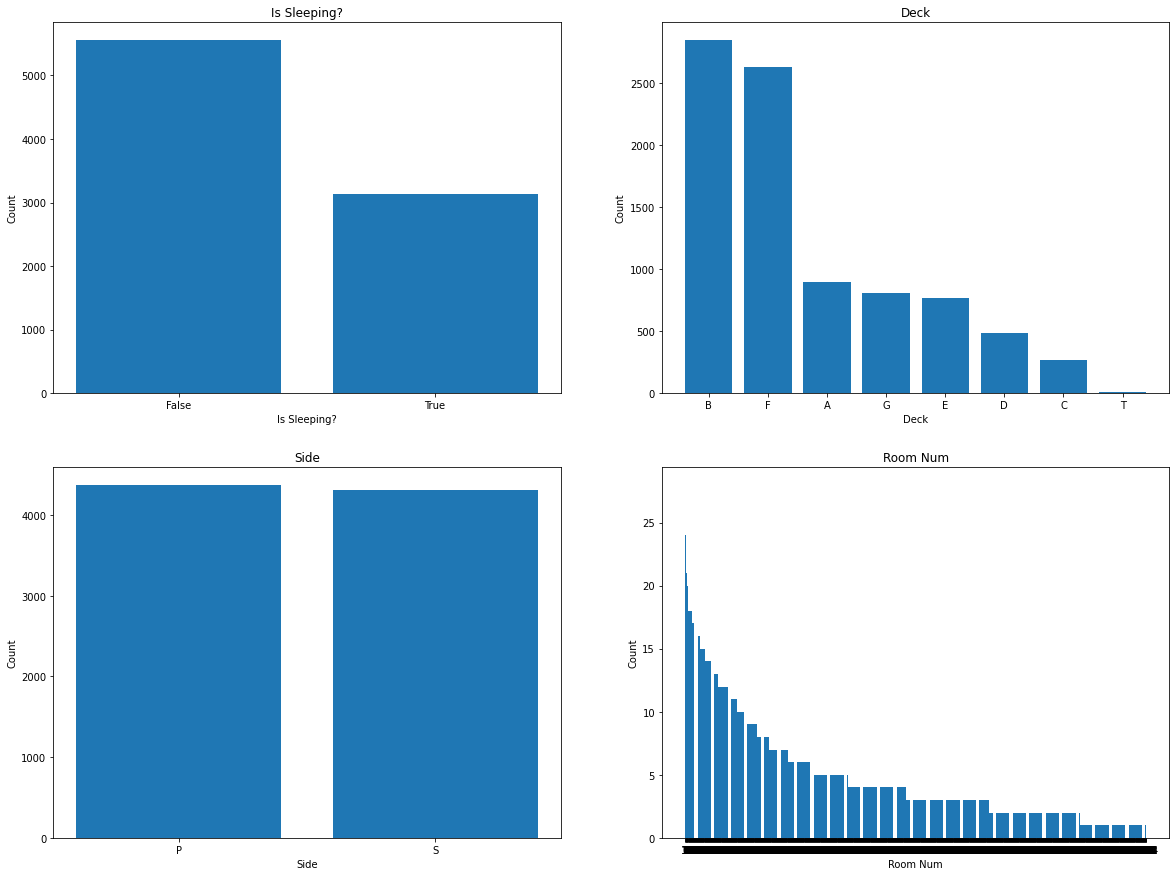

In [38]:
plt.figure()

plt.subplot(2,2,1)
plt.bar(["False","True"],train_df["CryoSleep"].value_counts())
plt.title("Is Sleeping?")
plt.ylabel("Count")
plt.xlabel("Is Sleeping?")

plt.subplot(2,2,2)
plt.bar(train_df["Deck"].dropna().unique(),train_df["Deck"].value_counts())
plt.title("Deck")
plt.xlabel("Deck")
plt.ylabel("Count")

plt.subplot(2,2,3)
plt.bar(train_df["Side"].dropna().unique(),train_df["Side"].value_counts())
plt.title("Side")
plt.xlabel("Side")
plt.ylabel("Count")

plt.subplot(2,2,4)
plt.bar(train_df["Num"].unique(),train_df["Num"].value_counts())
plt.title("Room Num")
plt.xlabel("Room Num")
plt.ylabel("Count")

plt.show()

In [39]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   PassengerId         8693 non-null   object  
 1   HomePlanet          8693 non-null   category
 2   CryoSleep           8693 non-null   bool    
 3   Destination         8693 non-null   category
 4   Age                 8693 non-null   float64 
 5   VIP                 8693 non-null   bool    
 6   RoomService         8693 non-null   float64 
 7   FoodCourt           8693 non-null   float64 
 8   ShoppingMall        8693 non-null   float64 
 9   Spa                 8693 non-null   float64 
 10  VRDeck              8693 non-null   float64 
 11  Transported         8693 non-null   bool    
 12  PassengerId_Ticket  8693 non-null   object  
 13  PassengerId_Unique  8693 non-null   object  
 14  IsGrouped           8693 non-null   bool    
 15  Deck                8693 non-null   ca

**Change object to categorycal for further labeling**

In [40]:
train_df[['Num','PassengerId_Unique','PassengerId_Ticket']] = train_df[['Num','PassengerId_Unique','PassengerId_Ticket']].astype('int64')

test_df[['Num','PassengerId_Unique','PassengerId_Ticket']] = test_df[['Num','PassengerId_Unique','PassengerId_Ticket']].astype('int64')

**Label categorical data to standarize everything (Deck, Side).**

In [41]:
label_encoder = LabelEncoder()

for i in list(train_df.columns):
    if train_df[i].dtype=='category':
        train_df[i]=label_encoder.fit_transform(train_df[i])

for i in list(test_df.columns):
    if test_df[i].dtype=='category':
        test_df[i]=label_encoder.fit_transform(test_df[i])

In [42]:
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,PassengerId_Ticket,PassengerId_Unique,IsGrouped,Deck,Num,Side,IsAdult,TotalSpent
0,0001_01,1,False,2,39.0,False,0.0,0.0,0.0,0.0,0.0,False,1,1,False,1,0,0,True,0.0
1,0002_01,0,False,2,24.0,False,109.0,9.0,25.0,549.0,44.0,True,2,1,False,5,0,1,True,736.0
2,0003_01,1,False,2,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,3,1,True,0,0,1,True,10383.0
3,0003_02,1,False,2,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,3,2,True,0,0,1,True,5176.0
4,0004_01,0,False,2,16.0,False,303.0,70.0,151.0,565.0,2.0,True,4,1,False,5,1,1,False,1091.0


**Here we make scaler to adjust the numeric data**

In [43]:
mlpc_train_df = train_df
mlpc_test_df = test_df

In [44]:
mask = ['HomePlanet','Destination','Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'PassengerId_Ticket', 'PassengerId_Unique', 'Deck', 'Num', 'Side', 'TotalSpent']
scaler = MinMaxScaler()

# Scale train df
scaler.fit(train_df[mask])
train_df[mask] = scaler.transform(train_df[mask])

# Scale test df
scaler.fit(test_df[mask])
test_df[mask] = scaler.transform(test_df[mask])

train_df.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,PassengerId_Ticket,PassengerId_Unique,IsGrouped,Deck,Num,Side,IsAdult,TotalSpent
0,0001_01,0.5,False,1.0,0.493671,False,0.000000,0.000000,0.000000,0.000000,0.000000,False,0.000000,0.000000,False,0.142857,0.000000,0.0,True,0.000000
1,0002_01,0.0,False,1.0,0.303797,False,0.007608,0.000302,0.001064,0.024500,0.001823,True,0.000108,0.000000,False,0.714286,0.000000,1.0,True,0.020452
2,0003_01,0.5,False,1.0,0.734177,True,0.003001,0.119948,0.000000,0.299670,0.002030,False,0.000216,0.000000,True,0.000000,0.000000,1.0,True,0.288521
3,0003_02,0.5,False,1.0,0.417722,False,0.000000,0.043035,0.015793,0.148563,0.007997,False,0.000216,0.142857,True,0.000000,0.000000,1.0,True,0.143830
4,0004_01,0.0,False,1.0,0.202532,False,0.021149,0.002348,0.006428,0.025214,0.000083,True,0.000323,0.000000,False,0.714286,0.000528,1.0,False,0.030317


In [45]:
MLPCScaler = StandardScaler()

#MLPC 

# Scale train df
MLPCScaler.fit(mlpc_train_df[mask])
mlpc_train_df[mask] = MLPCScaler.transform(mlpc_train_df[mask])

# Scale test df
MLPCScaler.fit(mlpc_test_df[mask])
mlpc_test_df[mask] = MLPCScaler.transform(mlpc_test_df[mask])


In [46]:
mlpc_train_df.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,PassengerId_Ticket,PassengerId_Unique,IsGrouped,Deck,Num,Side,IsAdult,TotalSpent
0,0001_01,0.416813,False,0.630187,0.709437,False,-0.337325,-0.284499,-0.287016,-0.274290,-0.266240,False,-1.734409,-0.491161,False,-1.852455,-1.169959,-1.006810,True,-0.519688
1,0002_01,-0.834346,False,0.630187,-0.336717,False,-0.172184,-0.278856,-0.245188,0.213727,-0.227425,True,-1.734034,-0.491161,False,0.391373,-1.169959,0.993236,True,-0.257408
2,0003_01,0.416813,False,0.630187,2.034566,True,-0.272178,1.957577,-0.287016,5.694812,-0.223015,False,-1.733660,-0.491161,True,-2.413412,-1.169959,0.993236,True,3.180377
3,0003_02,0.416813,False,0.630187,0.290975,False,-0.337325,0.519915,0.333704,2.684927,-0.095985,False,-1.733660,0.457443,True,-2.413412,-1.169959,0.993236,True,1.324821
4,0004_01,-0.834346,False,0.630187,-0.894666,False,0.121737,-0.240610,-0.034378,0.227950,-0.264476,True,-1.733286,-0.491161,False,0.391373,-1.168004,0.993236,False,-0.130901


**Now transform bool data into 0 and 1s**

In [47]:
onehot = OneHotEncoder()

for i in list(train_df.columns):
    if train_df[i].dtype=='bool':
        train_df[i]=label_encoder.fit_transform(train_df[i])
        
for i in list(test_df.columns):
    if test_df[i].dtype=='bool':
        test_df[i]=label_encoder.fit_transform(test_df[i])

**Now we got just numericall data**
FINAL TRAIN DATA FRAME

In [48]:
train_df.head()

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,PassengerId_Ticket,PassengerId_Unique,IsGrouped,Deck,Num,Side,IsAdult,TotalSpent
0,0001_01,0.416813,0,0.630187,0.709437,0,-0.337325,-0.284499,-0.287016,-0.274290,-0.266240,0,-1.734409,-0.491161,0,-1.852455,-1.169959,-1.006810,1,-0.519688
1,0002_01,-0.834346,0,0.630187,-0.336717,0,-0.172184,-0.278856,-0.245188,0.213727,-0.227425,1,-1.734034,-0.491161,0,0.391373,-1.169959,0.993236,1,-0.257408
2,0003_01,0.416813,0,0.630187,2.034566,1,-0.272178,1.957577,-0.287016,5.694812,-0.223015,0,-1.733660,-0.491161,1,-2.413412,-1.169959,0.993236,1,3.180377
3,0003_02,0.416813,0,0.630187,0.290975,0,-0.337325,0.519915,0.333704,2.684927,-0.095985,0,-1.733660,0.457443,1,-2.413412,-1.169959,0.993236,1,1.324821
4,0004_01,-0.834346,0,0.630187,-0.894666,0,0.121737,-0.240610,-0.034378,0.227950,-0.264476,1,-1.733286,-0.491161,0,0.391373,-1.168004,0.993236,0,-0.130901


In [49]:
print error to stop the notebook :D

SyntaxError: Missing parentheses in call to 'print'. Did you mean print(error to stop the notebook :D)? (1736281622.py, line 1)

# **INIT TRAINING MODELS**

**Setting up the variables**

In [50]:
X_train = train_df.drop(['PassengerId', 'Transported'], axis=1)
y_train = train_df['Transported']

X_test = test_df.drop(['PassengerId'], axis=1)

X_test2 = train_df.drop(['PassengerId','Transported'], axis=1)

X_train_mlpc = mlpc_train_df.drop(['PassengerId', 'Transported'], axis=1)
y_train_mlpc = mlpc_train_df['Transported']

X_test_mlpc = mlpc_test_df.drop(['PassengerId'], axis=1)

X_test2_mlpc = mlpc_train_df.drop(['PassengerId','Transported'], axis=1)

## **Start with XGB Classifier**

**Look for the best params**


** INIT TRAINING **

Fitting 10 folds for each of 55 candidates, totalling 550 fits
Fitting 10 folds for each of 55 candidates, totalling 550 fits
Best: -0.388215 using {'max_depth': 4, 'n_estimators': 46}
-0.403810 (0.017665) with: {'max_depth': 3, 'n_estimators': 40}
-0.403159 (0.017213) with: {'max_depth': 3, 'n_estimators': 41}
-0.402684 (0.017462) with: {'max_depth': 3, 'n_estimators': 42}
-0.402316 (0.017703) with: {'max_depth': 3, 'n_estimators': 43}
-0.402016 (0.017565) with: {'max_depth': 3, 'n_estimators': 44}
-0.401377 (0.017319) with: {'max_depth': 3, 'n_estimators': 45}
-0.401332 (0.017196) with: {'max_depth': 3, 'n_estimators': 46}
-0.400301 (0.017506) with: {'max_depth': 3, 'n_estimators': 47}
-0.399458 (0.017815) with: {'max_depth': 3, 'n_estimators': 48}
-0.399282 (0.018021) with: {'max_depth': 3, 'n_estimators': 49}
-0.398304 (0.018963) with: {'max_depth': 3, 'n_estimators': 50}
-0.388807 (0.019722) with: {'max_depth': 4, 'n_estimators': 40}
-0.388878 (0.020043) with

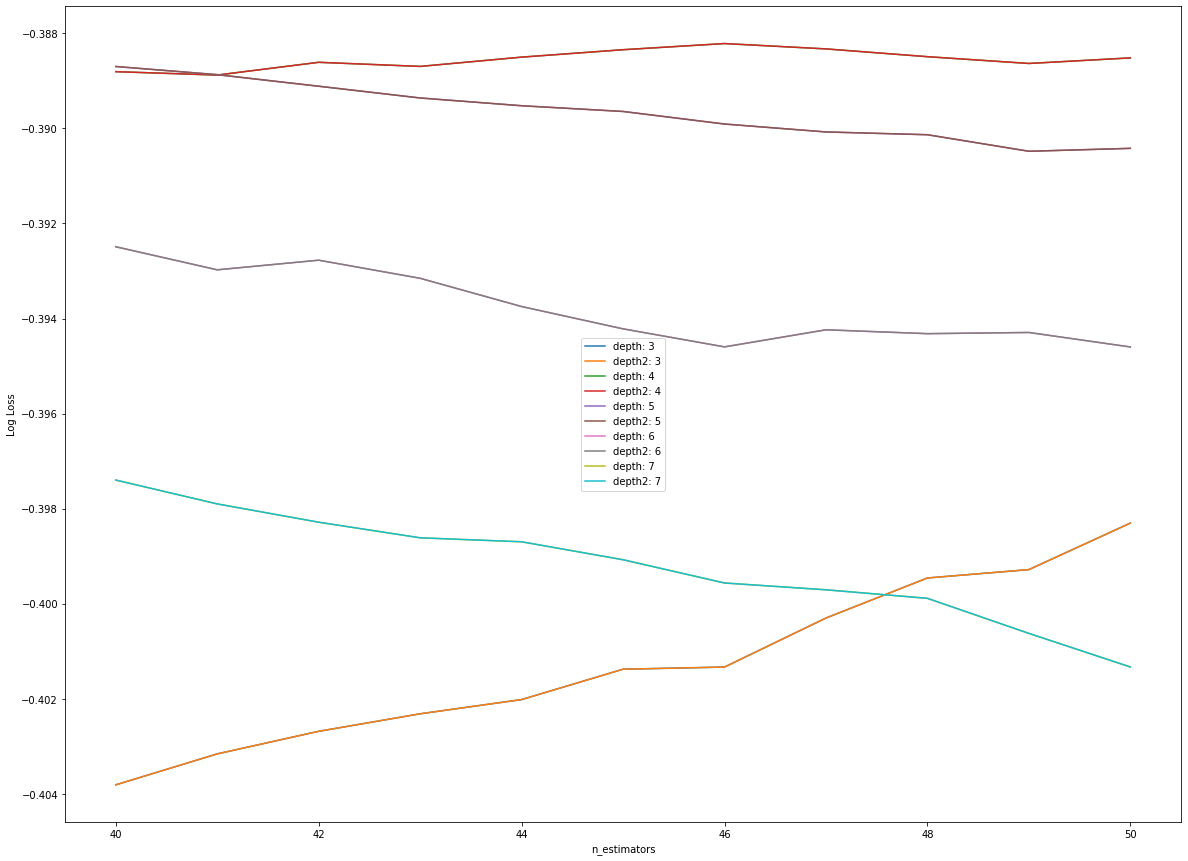

In [51]:
start_time = time.time()
print("\n** INIT TRAINING **\n")
model = xgb.XGBClassifier()
n_estimators = [40,41,42,43,44,45,46,47,48,49,50]
max_depth = [3,4,5,6,7]

param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold, verbose=1)
grid_result = grid_search.fit(X_train, y_train)
grid_result2 = grid_search.fit(X_train_mlpc, y_train_mlpc)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))
    
print("Best2: %f using %s" % (grid_result2.best_score_, grid_result2.best_params_))
means2 = grid_result2.cv_results_['mean_test_score']
stds2 = grid_result2.cv_results_['std_test_score']
params2 = grid_result2.cv_results_['params']

for mean, stdev, param in zip(means2, stds2, params2):
	print("%f (%f) with: %r" % (mean, stdev, param))

    
# plot results
scores = np.array(means).reshape(len(max_depth), len(n_estimators))
scores2 = np.array(means2).reshape(len(max_depth), len(n_estimators))

for i, value in enumerate(max_depth):
    plt.plot(n_estimators, scores[i], label='depth: ' + str(value))
    plt.plot(n_estimators, scores2[i], label='depth2: ' + str(value))
print("\n** TRAINING FINISHED IN ", (time.time()-start_time), " SECONDS")

plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('Log Loss')
plt.show()

#I tried too many n_estimators and depth and the best result always is 50 and 4.

**Use best estimator**

In [52]:
model = xgb.XGBClassifier(max_depth=4, n_estimators=46)
model.fit(X_train,y_train)

model2 = xgb.XGBClassifier(max_depth=4, n_estimators=46)
model2.fit(X_train_mlpc,y_train_mlpc)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=46, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)


**Predict**

In [53]:
predicted_y = model.predict(X_test)
predicted_y2 = model2.predict(X_test_mlpc)

**Create output DataFrame with prediction**

In [58]:
output = pd.DataFrame({'PassengerId': test_df["PassengerId"],
                       'Transported': predicted_y.astype('bool')})

output = output.set_index("PassengerId")
output["Transported"].value_counts()

True     2302
False    1975
Name: Transported, dtype: int64

**Export Data for submission**

In [59]:
#output.to_csv("XGBClassifier_SubmissionV3.csv")

## **Neural Network - Dont work yet**

In [64]:
from sklearn.neural_network import MLPClassifier

start_time = time.time()

model = MLPClassifier(hidden_layer_sizes = [100, 100], alpha = 5.0,
                   random_state = 0, solver='lbfgs', max_iter=5000).fit(X_train_mlpc, y_train_mlpc)

print('Accuracy of NN classifier on training set: {:.2f}'
     .format(model.score(X_train_mlpc, y_train_mlpc)))

print("\nMLPC Training model tooks: ", (time.time()-start_time), " seconds.")

Accuracy of NN classifier on training set: 0.95

MLPC Training model tooks:  666.3230082988739  seconds.


/opt/conda/lib/python3.7/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [65]:
mlpcresult = model.predict(X_test_mlpc)

In [66]:
output = pd.DataFrame({'PassengerId': mlpc_test_df["PassengerId"],
                       'Transported': mlpcresult.astype('bool')})
#output["Transported"].value_counts()
output = output.set_index("PassengerId")
output["Transported"].value_counts()

False    2180
True     2097
Name: Transported, dtype: int64

In [63]:
#output.to_csv("MPLCSubmissionV3.csv")

## **RandomForestClassifier**

In [80]:
#just for fun lets check the time

start_time = time.time()

params = {'max_depth': [10,30,50],
          'n_estimators': [1,10,50,100]}

model = RandomForestClassifier()

grid_model = GridSearchCV(model, param_grid=params, scoring="roc_auc")
grid_model.fit(X_train, y_train)

print('Tuned Random Forest best score {}'.format(grid_model.best_score_))
print('Tuned Random Forest best params {}'.format(grid_model.best_estimator_))
print("\nModel training took: ",(time.time()-start_time)," seconds")

Tuned Random Forest best score 0.8601409166736586
Tuned Random Forest best params RandomForestClassifier(max_depth=10, n_estimators=50)

Model training took:  28.490586042404175  seconds


**Now we can predict**

In [81]:
y_pred = grid_model.predict(X_test)
y_pred

array([0, 0, 1, ..., 1, 1, 0])

**Generate the submission DataFrame**

In [82]:
output = pd.DataFrame({'PassengerId': test_df["PassengerId"],
                       'Transported': y_pred.astype('bool')})
output["Transported"].value_counts()


False    2452
True     1825
Name: Transported, dtype: int64

**Save .csv file**

In [83]:
#output.to_csv('submission.csv', index=False)

## **KNeigborsClassifier model**

**Check the best n_neighbors value**

In [ ]:
start_time = time.time()

error = []

# Calculating MAE error for K values between 1 and 70
for i in range(1, 70):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    pred_i = knn.predict(X_test)
    mae = mean_absolute_error(y_train[0:4277], pred_i)
    error.append(mae)
    
print("This took: ", (time.time()-start_time), " seconds.")

**Plot n values to check the best**

In [ ]:
plt.figure()
plt.plot(np.array(range(1,70)),error,".-",color="red")
plt.title("N-Neighbors")
plt.xlabel("N-Neighbors")
plt.ylabel("Score")
plt.grid()
plt.show()

**Choose best n = 1**

In [ ]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
pred_i = knn.predict(X_test)

**Prepare output data**

In [ ]:
output = pd.DataFrame({'PassengerId': test_df["PassengerId"],
                       'Transported': pred_i.astype('bool')})
output = output.set_index("PassengerId")
output["Transported"].value_counts()

**Create .csv file**

In [ ]:
#output.to_csv("KNeighbors_SubmissionV3.csv")